In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
!pip install sentencepiece
import sentencepiece as spm

     |████████████████████████████████| 1.0MB 9.3MB/s 


In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.60', '1.4.0')

In [ ]:
df = pd.read_parquet('drive/My Drive/nlp-telugu/telugu_wikipedia_dataset.parquet')

In [4]:
df.shape, df.columns

((90000, 2), Index(['title', 'text'], dtype='object'))

In [5]:
texts = (df['title'] + ' ' + df['text']).tolist()
texts = [t for t in df['text'] if len(t.strip())>1]
print(len(texts))

83953


In [ ]:
df2 = pd.DataFrame(texts, columns = ['text'])

In [7]:
del df, texts
gc.collect()

0

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df2, test_size=0.2)
train_df.shape, test_df.shape

((67162, 1), (16791, 1))

In [ ]:
from inltk.tokenizer import TeluguTokenizer

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [ ]:
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')

In [12]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [ ]:
torch.cuda.set_device(0)

In [14]:
data_lm = TextLMDataBunch.from_df('/content/', train_df=train_df, valid_df=test_df,
                                  text_cols=["text"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_lm.data')


In [15]:
data_lm.batch_size

96

In [16]:
data_lm.show_batch()

idx,text
0,"▁ఇది ▁మండల ▁కేంద్రమైన ▁రావి క మతం ▁నుండి ▁10 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁అనకాపల్లి ▁నుండి ▁45 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది . ▁2011 ▁భారత ▁జనగణన ▁గణాంకాల ▁ప్రకారం ▁ఈ ▁గ్రామం ▁39 52 ▁ఇళ్లతో , ▁146 69 ▁జనాభాతో ▁10 52 ▁హెక్టార్లలో ▁విస్తరించి ▁ఉంది . ▁గ్రామంలో ▁మగవారి ▁సంఖ్య ▁70 66 , ▁ఆడవారి ▁సంఖ్య ▁76 03 . ▁షెడ్యూల్డ్ ▁కులాల ▁సంఖ్య ▁1893 ▁కాగా ▁షెడ్యూల్డ్ ▁తెగల ▁సంఖ్య ▁35 . ▁గ్రామం ▁యొక్క"
1,▁కంటే ▁ఎక్కువ ▁దూరంలో ▁ఉన్నాయి . ▁గ్రామంలో ▁కుళాయిల ▁ద్వారా ▁రక్షిత ▁మంచినీటి ▁సరఫరా ▁జరుగుతోంది . ▁బావుల ▁నీరు ▁కూడా ▁అందుబాటులో ▁ఉంది . ▁గ్రామంలో ▁ఏడాది ▁పొడుగునా ▁చేతిపంపుల ▁ద్వారా ▁నీరు ▁అందుతుంది . ▁బోరుబావుల ▁ద్వారా ▁కూడా ▁ఏడాది ▁పొడుగునా ▁నీరు ▁అందుతుంది . ▁చెరువు ▁ద్వారా ▁గ్రామానికి ▁తాగునీరు ▁లభిస్తుంది . ▁గ్రామంలో ▁మురుగునీటి ▁పారుదల ▁వ్యవస్థ ▁లేదు . ▁మురుగునీటి ని ▁నేరుగా ▁జలవనరుల్లోకి ▁వదులుతున్న ారు . ▁గ్రామంలో ▁సంపూర్ణ ▁పారిశుధ్య ▁పథకం ▁అమలవుతోంది . ▁సామాజిక ▁మరుగుదొడ్డి ▁సౌకర్యం ▁లేదు . ▁ఇంటింటిక ీ ▁తిరిగి ▁వ్యర్థాలను ▁సేకరించే
2,", ▁లక్నో , ▁ దారు ల్ ▁ఇస్లాం , ▁సుల్తాన్ ▁పూర్ , ▁తుగ్లక్ ▁పూర్ , ▁దౌ ల త ాబాదు , ▁ముల్ క్ - ఎ - తి ల ంగ్ ▁( తెలంగాణ ా ) ▁లలో ▁ముద్రించ ేవాడు . ▁ఇ ంతవరకూ ▁30 ▁రకాల ▁బిల్ లన్ ▁నాణేల ▁గూర్చి ▁తెలిసింది . ▁తుగ్లక్ ▁కాలం ▁నాటి ▁నాణెం ▁బలవంతంగా ▁ప్రవేశ ▁పెట్ట బడిన ▁నాణెం ▁తుగ్లక్ ▁అనీ , ▁పిచ్చి ▁తుగ్లక్ ▁అనీ , ▁తెలుగు ▁సినిమాలలో ▁సైతం , ▁ఇతడి ▁పేరు ▁ఒక ▁తరం లో"
3,"▁అతనిని ▁నా ▁గురువుగా ▁ , ▁' పథ ▁నిర్దేశ కు ని ' ▁గా ▁భావ ిస్తాను "" ▁అని ▁ఆయన ▁అన్నాడు . ▁' తిరు ప్పా వై ' ▁పై ▁తెలుగులో ▁శ్రీ బా ష్య ం ▁చేసిన ▁ఉపన్యాసాల ▁ నోట్స్ ▁తీసుకున్నాడు . ▁తరువాత ▁అతను ▁' తిరు ప్పా వై ' ▁ను ▁ఆంగ్లంలో కి ▁అనువదించాడు . ▁దీనిని ▁ఆంగ్ల ▁అనువాద ాన్ని ▁తిరుమల ▁తిరుపతి ▁దేవస్థాన ాలు ▁ప్రచురించ ాయి . ▁శ్రీ బా ష్య ం ▁' ▁వాల్మీకి ▁రామాయణం ▁' ▁గురించి ▁రాసిన ▁తెలుగు"
4,"▁జరిగిన ▁చాలా ▁నెలల ▁తరువాత ▁భారత్ ▁తన విగా ▁భావిస్తున్న ▁అ క్సా య్ ▁చి న్ ▁వంటి ▁అనేక ▁ప్రాంతాలను ▁చూప ిస్తూ ▁భారతదేశ ▁మ్యా పు లను ▁ప్రచురించ వలసినదిగా ▁నెహ్రూ ▁ఆదేశించాడు .[30] ▁ఈ ▁కొత్త ▁మ్యా పు ల్లో <unk> ▁n e f a ▁ప్రాంతంలోని ▁శిఖరాల ను ▁సరిహద్దు గా ▁సూచించారు . ▁ఈ ▁సరిహద్దు ▁మెక్ ▁మహా న్ ▁రేఖ కు ▁ఉత్తర ంగా ▁ఉన్నప్పటికీ ▁అలాగే ▁చూపించారు .[8] ▁1959 ▁లో ▁టిబెట్ ▁తిరుగుబాటు ▁విఫలమవ డం , ▁14 ▁వ ▁ద లై లా మా"


In [17]:
len(data_lm.vocab.itos)

25000

In [ ]:
learn = language_model_learner(data_lm, TransformerXL, pretrained=False)

In [19]:
gc.collect()

0

In [ ]:
learn.lr_find()


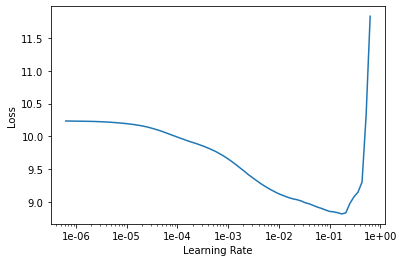

In [21]:
learn.recorder.plot()

In [22]:
learn.model


SequentialRNN(
  (0): TransformerXL(
    (encoder): Embedding(25000, 410)
    (pos_enc): PositionalEncoding()
    (drop_emb): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadRelativeAttention(
          (attention): Linear(in_features=410, out_features=1230, bias=False)
          (out): Linear(in_features=410, out_features=410, bias=False)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((410,), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=410, out_features=410, bias=False)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=410, out_features=2100, bias=True)
            (1): ReLU(inplace=True)
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=2100, out_features=410, bias=True)
            (4): Dropout(p=0.1, inplace=False)
          

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))
learn.save('first', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.418655,3.382510,0.479361,2:10:48


In [ ]:
TEXT = "ఇది మండల కేంద్రమైన రంపచోడవరం నుండి"
N_WORDS = 20
N_SENTENCES = 2

In [28]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))


ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁25 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁తుని ▁నుండి ▁18 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .
ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁11 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁విశాఖపట్నం ▁నుండి ▁178 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .


In [29]:
np.exp(3.38251)

29.44458434563783

In [ ]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [ ]:
!cp -r 'export.pkl' 'drive/My Drive/nlp-telugu/transformer/'

In [ ]:
defaults.device = torch.device('cpu')

In [33]:
learn = load_learner('./')

In [34]:
encoder = get_model(learn.model)[0]
encoder.state_dict()['encoder.weight'].shape

torch.Size([25000, 410])

In [35]:
embeddings = encoder.state_dict()['encoder.weight']
embeddings = np.array(embeddings)
embeddings[0].shape

(410,)

In [36]:
df = pd.DataFrame(embeddings)
df.shape

(25000, 410)

In [ ]:
df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

In [38]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409
0,0.168456,0.250936,0.103543,-0.172454,-0.041535,-0.045538,0.061835,0.232078,-0.176761,0.153493,-0.011900,-0.187309,-0.233887,-0.147983,0.106419,0.175018,-0.049819,0.120155,-0.034908,0.008750,0.110372,0.146387,-0.130649,-0.140149,-0.301429,-0.011796,-0.036150,0.098545,-0.143862,-0.007573,-0.024107,0.176211,-0.197268,-0.038095,0.152785,0.290618,0.189962,0.015514,-0.065284,0.271778,...,-0.117204,-0.101579,-0.035541,-0.161840,0.170878,-0.186538,-0.057563,0.220164,-0.063298,0.025578,0.113246,-0.269617,-0.105775,0.016454,0.209866,-0.133459,0.073281,-0.031263,0.415724,0.151674,-0.171354,0.145311,0.207090,-0.101140,-0.064890,0.122351,-0.207216,-0.157048,0.308678,-0.134374,-0.121189,0.199974,0.065700,-0.021250,0.177341,-0.291452,0.143585,0.061026,0.078947,0.155917
1,-0.220249,-0.188598,-0.345878,0.112449,0.023840,0.101148,-0.033054,-0.144005,0.423079,0.006505,0.057473,-0.179813,0.037655,-0.185398,0.250641,0.082603,0.149942,0.041512,0.287772,0.145918,-0.398235,-0.076679,0.004896,0.432985,0.510667,-0.146145,-0.098704,0.074941,0.277632,0.215441,0.297296,-0.539252,0.032001,-0.156901,-0.296157,-0.043996,-0.093337,-0.002278,-0.083677,-0.132683,...,0.282637,-0.166021,-0.158601,0.300466,0.112300,0.216768,0.205630,-0.148975,-0.038599,0.128784,0.289732,0.540004,0.057157,0.116406,-0.278459,0.028926,0.160498,0.369616,-0.340823,-0.306371,-0.129633,0.073938,0.078633,-0.234326,-0.124070,-0.263269,0.102418,0.114218,-0.386652,0.219183,0.151405,-0.082154,0.032850,0.136987,0.057410,0.396601,-0.054791,0.152203,-0.138082,-0.218087
2,-0.221206,-0.199571,-0.370084,0.126621,0.025762,0.102211,-0.025885,-0.145297,0.439236,0.002734,0.062535,-0.146085,0.033095,-0.180524,0.230115,0.067725,0.104293,0.011355,0.268263,0.128675,-0.382109,-0.101414,0.003718,0.431207,0.499839,-0.146140,-0.121144,0.075234,0.291923,0.218704,0.311183,-0.528095,0.006491,-0.182094,-0.291808,-0.052686,-0.086928,-0.000844,-0.067001,-0.154394,...,0.278401,-0.165919,-0.141969,0.323553,0.120676,0.203688,0.198097,-0.149195,-0.029635,0.115855,0.310436,0.559299,0.054549,0.121131,-0.262636,0.008539,0.157656,0.375482,-0.344028,-0.294314,-0.096098,0.078326,0.067719,-0.236995,-0.133526,-0.257952,0.152134,0.113968,-0.371074,0.230251,0.154383,-0.068707,0.040037,0.141809,0.047365,0.377341,-0.068729,0.150654,-0.132315,-0.233182
3,0.242197,0.227901,0.124662,-0.277270,-0.232432,-0.123582,0.156905,0.132048,-0.071580,0.291700,0.341650,-0.336078,0.234957,-0.267962,-0.150138,0.498996,-0.204145,0.190308,-0.114767,-0.302684,0.104871,0.153976,0.266462,0.026090,-0.279269,0.307306,0.234660,-0.319518,-0.252226,0.202733,-0.314149,0.250380,-0.181458,-0.226488,0.046271,0.208720,0.121967,0.165322,-0.166402,0.306722,...,0.330487,0.199902,0.206052,0.421675,0.217915,0.187960,-0.222863,0.280560,0.078392,-0.406938,0.242978,-0.308894,-0.220781,0.044165,0.208608,0.309743,-0.383192,0.097210,0.253515,0.050509,0.167909,0.162783,-0.200553,0.145214,-0.290715,0.222507,0.546484,-0.217568,0.209692,-0.378208,-0.124360,0.256641,0.113278,-0.003507,-0.099903,-0.221089,0.314803,-0.174330,0.278329,0.182786
4,-0.350860,0.209580,0.249544,-0.309201,-0.129478,-0.198060,-0.070070,0.255033,-0.190754,0.138165,-0.190626,-0.130491,-0.185311,0.217766,0.013398,-0.312968,-0.268597,0.204573,-0.187261,-0.336301,-0.085469,0.181205,-0.289729,-0.228696,-0.182647,0.071288,0.154409,-0.208595,-0.266289,-0.139497,-0.304062,0.265459,-0.235694,-0.053357,0.167990,0.215649,-0.359658,0.238233,-0.060195,0.198973,...,0.246661,0.242423,0.048206,-0.118178,-0.193151,-0.118218,-0.104784,0.267716,0.139456,-0.065833,-0.230980,-0.271742,-0.074918,-0.228812,0.200427,0.355319,-0.290702,0.254139,0.350473,0.202767,-0.050586,-0.002205,0.436756,0.288826,-0.283149,-0.032611,-0.313930,-0.305459,0.278596,-0.235510,-

In [39]:
df2 = pd.DataFrame(itos)
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,.
4,","


In [ ]:

df2.to_csv('embeddings_transformer_metadata.tsv', sep='\t', index=False, header=False)

In [41]:
encoder.state_dict()['encoder.weight'][1]

tensor([-0.2202, -0.1886, -0.3459,  0.1124,  0.0238,  0.1011, -0.0331, -0.1440,
         0.4231,  0.0065,  0.0575, -0.1798,  0.0377, -0.1854,  0.2506,  0.0826,
         0.1499,  0.0415,  0.2878,  0.1459, -0.3982, -0.0767,  0.0049,  0.4330,
         0.5107, -0.1461, -0.0987,  0.0749,  0.2776,  0.2154,  0.2973, -0.5393,
         0.0320, -0.1569, -0.2962, -0.0440, -0.0933, -0.0023, -0.0837, -0.1327,
         0.2630, -0.1078, -0.0708, -0.2659,  0.0255,  0.2543, -0.2125,  0.1126,
         0.0870,  0.1243, -0.2405,  0.0682, -0.1645, -0.1054, -0.2425,  0.1273,
         0.1253,  0.0968,  0.0073,  0.2726,  0.4936,  0.2044,  0.2313,  0.3345,
         0.1602, -0.0084,  0.0213,  0.1490, -0.1309,  0.0580, -0.0496,  0.3038,
        -0.1837, -0.0866,  0.3255, -0.1287,  0.2909, -0.1200, -0.1072, -0.3180,
        -0.2481, -0.2994,  0.0709,  0.1636, -0.3588, -0.0551,  0.1584, -0.1144,
        -0.0661, -0.0121, -0.0988,  0.1080,  0.0884, -0.0399,  0.2740,  0.0260,
         0.4446, -0.1439, -0.1277, -0.20

In [ ]:
!cp -r 'embeddings.tsv' 'drive/My Drive/nlp-telugu/transformer/'